
# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones - Edición 2023

## Análisis y visualización de datos

### Trabajo práctico entregable - Grupo 22 - Parte 1

**Integrantes:**
- Chevallier-Boutell, Ignacio José
- Córdoba, Florencia
- Ribetto, Federico
- Rosa, Santiago

**Seguimiento:** Meinardi, Vanesa

---

## Librerías

In [1]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

pd.set_option('display.max_rows', 1000) # cambiar el número de filas que se mostrarán usando display.max_rows.
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

sns.set_context('talk')
sns.set_theme(style='white')

## Lectura del dataset

El dataset a utilizar es la encuesta Sysarmy del año 2022 versión 2, en formato csv, la cual es una una encuesta personal y voluntaria que busca relevar información sobre salarios y condiciones de trabajo de programadores, que se realiza anualmente. Se analizarán sólo los datos provenientes de Argentina. 

Se utilizará un dataset que ya ha tenido un pretratamiento: 
* Se eliminó el encabezado de la encuesta original.
* Se renombraron las columnas.

Este data set está disponible en internet, desde donde lo usaremos.

In [2]:
url = 'https://raw.githubusercontent.com/DiploDatos/AnalisisyVisualizacion/master/sysarmy_survey_2022_processed.csv'
df = pd.read_csv(url)
total_ans = len(df) # cantidad de respuestas en el dataset

---
# Ejercicio 1 - Análisis descriptivo

## Selección de columnas

En este primer ejercicio, debemos dar respuesta a **¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**. Para ello, creemos que las columnas que contienen la información relevante son salary_monthly_BRUTO, salary_monthly_NETO y tools_programming_languages. Crearemos un nuevo DataFrame que contenga entonces sólo esta información. Luego, elimnamos las filas que están vacías.

In [3]:
relevant_columns = ["salary_monthly_BRUTO","salary_monthly_NETO","tools_programming_languages"]
df1 = df[relevant_columns] # Nuevo DataFrame

print(f'Cantidad inicial de filas: {total_ans}.')
df1 = df1.dropna(subset=relevant_columns)
print(f'Quedan {len(df1)} filas.')

Cantidad inicial de filas: 5358.
Quedan 5356 filas.


## Análisis preliminar

La estadística descriptiva del sueldo bruto muestra que hay una gran dispersión de datos: el sueldo bruto promedio es de $363.445, pero hay gente que llega a cobrar hasta 28 millones de pesos (más de 77 veces la media). Esto se ve reflejando también en su gran desviación estándar. Vemos también que hay gente que supuestamente tiene un sueldo nulo. Algo similar se ve observa con el sueldo neto.

In [4]:
print('Resultados del describe:')
print(df1.describe().round(0))

Resultados del describe:
       salary_monthly_BRUTO  salary_monthly_NETO
count                5356.0               5356.0
mean               363445.0             276969.0
std                544015.0             402009.0
min                     0.0                  0.0
25%                150000.0             118565.0
50%                256000.0             201000.0
75%                411948.0             294000.0
max              28000000.0           15000000.0


Esto mismo lo apreciamos gráficamente: vemos que la distribución es extremadamente asimétrica, teniendo una cola ampliamente extendida hacia la derecha. Además, considerando que el Salario Mínimo Vital y Móvil (SMVM) en Marzo de 2023 es de $80.342, hay varias respuestas que caen por debajo de este valor.

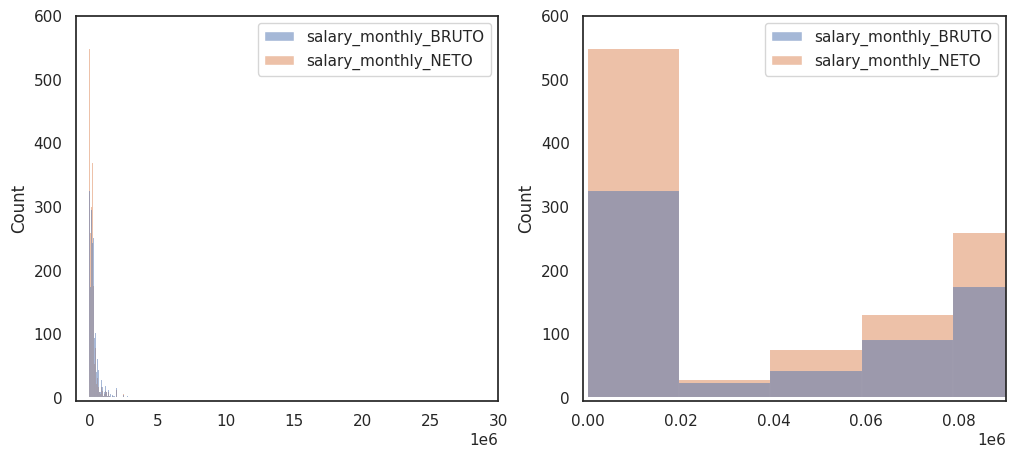

In [5]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

sns.histplot(df1, ax=axs[0], color='steelblue')
axs[0].ticklabel_format(style='sci', axis='x', scilimits=(6,6))
axs[0].set_ylim((-5,600))
axs[0].set_xlim((-1*10**6,30*10**6))

sns.histplot(df1, ax=axs[1], color='steelblue')
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(6,6))
axs[1].set_ylim((-5,600))
axs[1].set_xlim((-1000,9*10**4))

plt.show()

Analicemos ahora la relación entre el sueldo bruto y el neto. Sabemos que el sueldo bruto tiene que ser estrictamente mayor que el sueldo neto. Esto implica que, gráficamente, todos los puntos deberían caer por encima de la diagonal princial (marcada en rojo). Limpiamos entonces los datos, considerando esta condición. Notamos también que hay una serie de datos encolumnados en torno a un sueldo neto nulo.

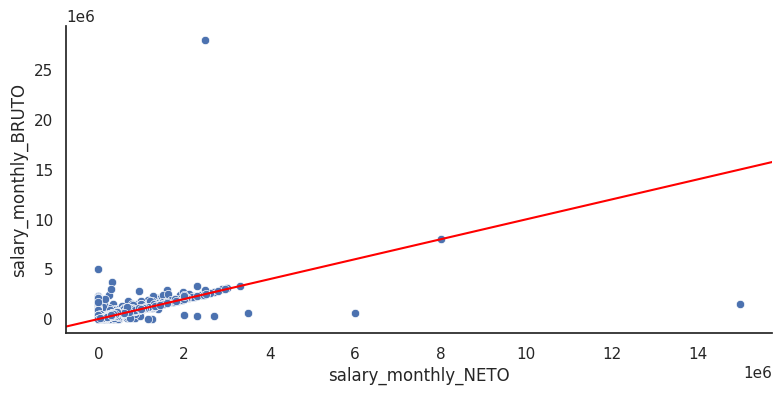

In [6]:
sns.pairplot(data=df1, y_vars=['salary_monthly_BRUTO'], x_vars=['salary_monthly_NETO'], aspect=2, height=4)
plt.ticklabel_format(style='sci', axis='both', scilimits=(6,6))
plt.axline(xy1=(10000, 10000), xy2=(2000000, 2000000), color="red")

## Filtrado/limpieza

Primero vamos a eliminar aquellos datos que no cumplan con la condición de que el sueldo bruto sea estrictamente mayor que el neto. Además, dada la pregunta que queremos responder, vamos a quedarnos con aquellas personas que cobran desde un SMVM hasta hasta 2 millones de pesos, inclusive, imponiendo estas condiciones sobre el sueldo neto.

In [7]:
print(f'Con todos los datos, teníamos {len(df1)} filas.')

df_acot = df1
df_acot = df_acot[df_acot["salary_monthly_BRUTO"]>df_acot["salary_monthly_NETO"]] # Filtramos bruto > neto

SMVM = 80342
df_acot = df_acot[df_acot["salary_monthly_NETO"]>=SMVM] # Filtramos desde el SMVM.
df_acot = df_acot[df_acot["salary_monthly_NETO"]<=2*1e6] # Filtramoshasta 2 millones.

print(f'Luego de filtrar, nos quedan {len(df_acot)} filas.')



Con todos los datos, teníamos 5356 filas.
Luego de filtrar, nos quedan 3931 filas.


Luego de filtrar, repetimos el pairplot y vemos que ahora tiene más sentido.

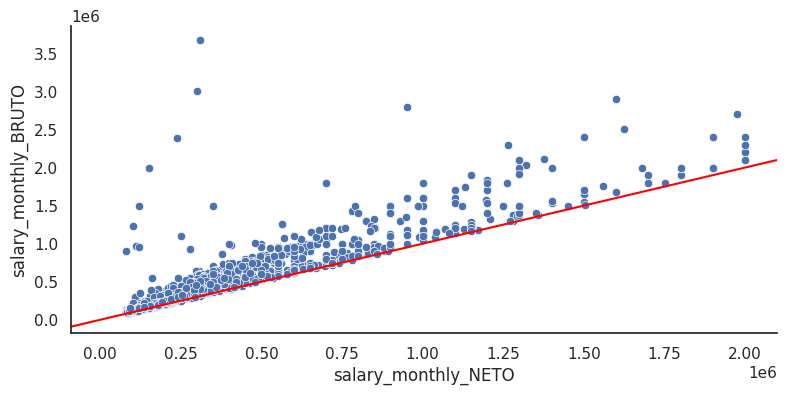

In [8]:
sns.pairplot(data=df_acot, y_vars=['salary_monthly_BRUTO'], x_vars=['salary_monthly_NETO'], aspect=2, height=4)
plt.ticklabel_format(style='sci', axis='both', scilimits=(6,6))
plt.axline(xy1=(10000, 10000), xy2=(2000000, 2000000), color="red")

Al repetir los histogramas, vemos que aún tenemos una distribución bastante asimetríca con muchos puntos a derecha, tanto en bruto como en neto.

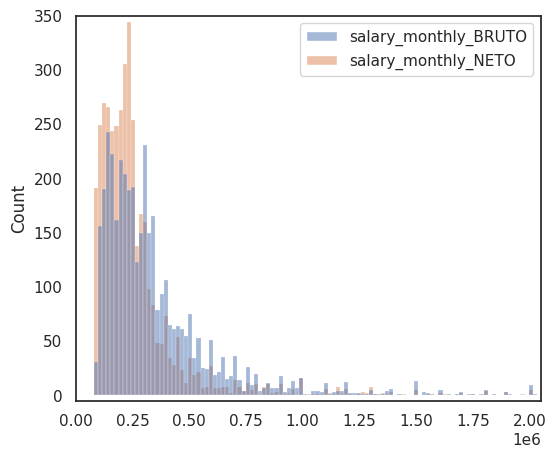

In [9]:
fig, axs = plt.subplots(figsize=(6,5))

sns.histplot(df_acot, ax=axs, color='steelblue')
axs.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
axs.set_ylim((-5,350))
axs.set_xlim((0,2.05*10**6))

plt.show()

## Selección de la porción central de la distribución

Consideramos que sería apropiado tomar el 85 % central de nuestra muestra para llevar a cabo el análisis. Como suele de ser de interés el sueldo "de bolsillo" (el neto), seguiremos adelante considerando sólo el sueldo neto y dejando de lado el bruto.

In [10]:
print(f'Teníamos {len(df_acot)} filas.')

df85 = df_acot[["salary_monthly_NETO","tools_programming_languages"]] # Nuevo DataFrame

k = 15
percentile_inf = df85["salary_monthly_NETO"].quantile(k * 0.5 / 100)
percentile_sup = df85["salary_monthly_NETO"].quantile((100 - k * 0.5) / 100)

df85 = df85[df85["salary_monthly_NETO"] > percentile_inf]
df85 = df85[df85["salary_monthly_NETO"] < percentile_sup]

print(f'Tomando el 85% central ahora tenemos {len(df85)} filas.')


Teníamos 3931 filas.
Tomando el 85% central ahora tenemos 3338 filas.


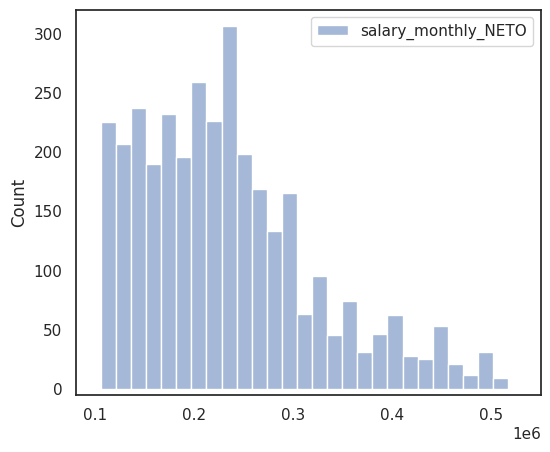

In [11]:
fig, axs = plt.subplots(figsize=(6,5))

sns.histplot(df85, ax=axs, color='steelblue')
axs.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
axs.set_ylim((-5,320))
axs.set_xlim((80000, 0.55*10**6))

plt.show()

## Selección de lenguajes de programación a analizar



La columna que contiene información sobre los lenguajes de programación utilizados es `tools_programming_languages`, la cual no hemos considerado hasta ahora. Lo primero que hay que hacer es eliminar aquellas entradas cuya respuesta sea "Ninguna de las anteriores". Luego  separar las listas de lenguajes, para que queden cada uno por su cuenta, asociado al respectivo sueldo neto. En la columna `programming_language` se encuentra cada lenguaje por separado (las filas con igual índice hacen referencia a la misma persona).

In [38]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df85.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)

new_relevant_columns = ["salary_monthly_NETO","tools_programming_languages", "cured_programming_languages"]

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df85.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df85[new_relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:5]

/tmp/ipykernel_18188/3400505666.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(pd.Series).stack()\


,programming_language,salary_monthly_NETO,tools_programming_languages,cured_programming_languages
0,python,245000.0,Python,[python]
2,javascript,115000.0,"Javascript, PHP, Python","[javascript, php, python]"
2,php,115000.0,"Javascript, PHP, Python","[javascript, php, python]"
2,python,115000.0,"Javascript, PHP, Python","[javascript, php, python]"
4,css,125000.0,"CSS, HTML, Javascript","[css, html, javascript]"


Si contamos cuántas veces aparece cada lenguaje y ordenamos de manera creciente, vemos que los 6 lenguajes más usados son sql, javascript, html, python, css y java, llevándose el 62% de la población. Éstos son los lenguajes que consideraremos en nuestro análisis.

In [49]:
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})

print(language_count[:10])

print(f'Cantidad total de entradas: {len(df_lang)}.')
top6 = np.sum(language_count["frequency"][0:6])
print(f'Entradas en los 6 más populares: {top6}.')
print(f'Porcentaje de los 6 lenguajes más usados: {top6 * 100 / len(df_lang):.0f}%.')


     language  frequency
0         sql       1357
1  javascript       1293
2        html        985
3      python        913
4         css        655
5        java        632
6  bash/shell        558
7  typescript        540
8        .net        443
9         php        376
Cantidad total de entradas: 9381.
Entradas en los 6 más populares: 5835.
Porcentaje de los 6 lenguajes más usados: 62%.


## Reformulación de la pregunta inicial

La pregunta que nos hacemos ahora es la siguiente. Considerando que en Argentina el SMVM en Marzo de 2023 es de $80.342 y que los 6 lenguajes de programación más populares son sql, javascript, html, python, css y java, ¿cuál de estos lenguajes de programación están asociados a los mejores salarios de bolsillo, considerando un sueldo mensual neto desde los $80.342 hasta los 2 millones de pesos?

A continuación construimos el DataFrame que nos servirá para responder esta pregunta.

In [54]:
interesting_languages = ["sql", "javascript", "html", "python", "css", "java"]
filtered_df_lang = df_lang[df_lang.programming_language.isin(interesting_languages)]

print(filtered_df_lang[:5])
print(len(filtered_df_lang))

  programming_language  salary_monthly_NETO tools_programming_languages cured_programming_languages
0               python             245000.0                      Python                    [python]
2           javascript             115000.0     Javascript, PHP, Python   [javascript, php, python]
2               python             115000.0     Javascript, PHP, Python   [javascript, php, python]
4                  css             125000.0       CSS, HTML, Javascript     [css, html, javascript]
4                 html             125000.0       CSS, HTML, Javascript     [css, html, javascript]
5835


# Hasta acá está chequeado

---

2. ...
  * Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
  * Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.
3. Seleccionar métricas que ayuden a responder la pregunta, y los métodos para analizarlas. Elegir UNA de las siguientes opciones:
  * Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante.
  * Comparar medidas de estadística descriptiva sobre la distribución de salario para cada lenguaje. Sean creativos, la estadística descriptiva nos permite decir cosas como: "el 10% de los mejores sueldos los ganan, en su mayoría, programadores que saben kotlin!" (donde *mayoría* es un término medio engañoso que sólo significa más del 50%). Para comparar múltiples lenguajes, les recomendamos usar también visualizaciones.
  * Comparar probabilidades. Por ejemplo: "Si sabés Python o Java, tenés un 30% más de chances de ganar arriba de 100K".

Si lo consideran necesario, realicen varias iteraciones. Es decir, si encuentran que las distribuciones de los lenguajes de programación que seleccionaron inicialmente no son muy diferentes, pueden re-hacer el análisis usando sólo los lenguajes de programación que son diferentes.

---

In [16]:

df_lang_copy = df_lang
lang_list=["sql","javascript","html","python","css","java"]
ii=0

print(df_lang_copy)
for lang in df_lang_copy["programming_language"]:
    if lang not in lang_list:
        df_lang_copy.loc[ii,"programming_language"]="otro"  #esto puede estar mal
    ii+=1

print(df_lang_copy)

#hacer: graficos de cajas por lenguajes
#       histogramas por lenguajes



     programming_language  salary_monthly_NETO tools_programming_languages   cured_programming_languages
0                  python             245000.0                      Python                      [python]
2              javascript             115000.0     Javascript, PHP, Python     [javascript, php, python]
2                     php             115000.0     Javascript, PHP, Python     [javascript, php, python]
2                  python             115000.0     Javascript, PHP, Python     [javascript, php, python]
4                     css             125000.0       CSS, HTML, Javascript       [css, html, javascript]
...                   ...                  ...                         ...                           ...
5348           javascript             294000.0  .NET, C#, Java, Javascript  [.net, c#, java, javascript]
5355                 html             190900.0                   HTML, SQL                   [html, sql]
5355                  sql             190900.0         

## Filtrado de lenguajes relevantes

El siguiente código permite seleccionar sólo las filas donde el valor de la columna `programming_language` se encuentre en la lista `interesting_languages`.

In [17]:
# Filter out languages that we want to exclude
# Complete here with your selected list.
interesting_languages = ["python"]
filtered_df_lang = df_lang[df_lang.programming_language.isin(interesting_languages)]
filtered_df_lang[:5]

,programming_language,salary_monthly_NETO,tools_programming_languages,cured_programming_languages
0,python,245000.0,Python,[python]
19,python,200000.0,"Python, SQL","[python, sql]"
22,python,245000.0,Python,[python]
30,python,183000.0,"Bash/Shell, Python, SQL","[bash/shell, python, sql]"
34,python,163000.0,".NET, C#, CSS, HTML, Python, SQL, VBA","[.net, c#, css, html, python, sql, vba]"


# Ejercicio 2 - Densidades y varias variables

Responder a la pregunta general: **¿Que herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?**

Para ello considere (igual al ejercicio Anterior):
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en sub-poblaciones. 

In [18]:
print(df.keys())
df2 = df["salary_monthly_NETO", "profile_years_experience", "profile_age", "work_province", "profile_gender"]


# fig = plt.figure(figsize=(6,4))
# ax = fig.add_subplot(111)
# ax.scatter(df_lang["programming_language"], df_lang["salary_monthly_BRUTO"])
# fig.tight_layout()


Index(['work_country', 'work_province', 'work_dedication', 'work_contract_type', 'salary_monthly_BRUTO', 'salary_monthly_NETO', 'numero', 'salary_in_usd', 'salary_last_dollar_value', 'salary_pay_cripto', 'salary_%_cripto', 'salary_has_bonus', 'salary_bonus_tied_to', 'salary_inflation_adjustment', 'salary_percentage_inflation_adjustment', 'salary_month_last_inflation_adjustment', 'salary_comparison_last_semester', 'salary_benefit', 'salary_satisfaction', 'Trabajo de', 'profile_years_experience', 'work_years_in_company', 'work_years_in_current_position', 'work_people_in_charge_of', 'tools_platform', 'tools_programming_languages', 'tools_frameworks', 'tools_data_bases', 'tools_qa_testing', 'company_employee_number', 'work_work_modality', 'Si trabajas bajo un esquema híbrido ¿Cuántos días a la semana vas a la oficina?', 'company_recommended', 'profile_studies_level', 'profile_studies_level_state', 'profile_career', 'profile_university', 'profile_boot_camp', 'profile_boot_camp_carrer',
    

KeyError: ('salary_monthly_NETO', 'profile_years_experience', 'profile_age', 'work_province', 'profile_gender')

## a) Densidad conjunta

Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa




## b) Asociación

* Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría



## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación






## d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)
